# LOWESS

散布図に従う近似線を描くために開発された局所回帰。
**LOESS (locally estimated scatterplot smoothing)** や **LOWESS (locally weighted scatterplot smoothing)** と呼ばれる。

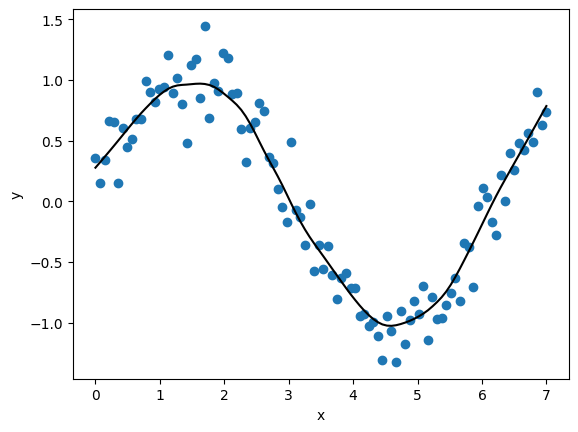

In [119]:
import numpy as np
np.random.seed(0)
x = np.linspace(0, 7, 100)
y = np.sin(x) + np.random.normal(0, 0.2, 100)

import statsmodels.api as sm
smoothed = sm.nonparametric.lowess(exog=x, endog=y, frac=0.2, it=3)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")
ax.set(xlabel="x", ylabel="y")
fig.show()

## 古典的なLOWESSのアルゴリズム

[Cleveland, W. S. (1979).](https://sites.oxy.edu/lengyel/m150/other/Robust%20Locally%20Weighted%20Regression%20and%20Smoothing%20Scatterplots_JASA1997_Cleveland.pdf) に記されたアルゴリズムは以下の通り。

$i$番目のサンプルの目的変数$y_i$を特徴量$x_i$とノンパラメトリックの平滑化関数$g(x_i)$で近似することを考える。

$$
y_i = g(x_i) + \epsilon_i
$$

ここで$\epsilon_i$は平均0で分散が一定の確率変数である。



**重みの計算：**

$x_i$について、$j=1,\dots,n$にわたって$|x_i - x_j|$で距離を測り、$r$番目に近いサンプルとの距離を$h_i$とする。

重み関数$W(\cdot)$を用いて、$k=1,\dots,n$について

$$
w_k(x_i) = W(h_i^{-1}(x_k - x_i))
$$

を計算する

重み関数$W(\cdot)$は以下の性質を満たすものとする

1. $|x| < 1$について $W(x) > 0$
2. $W(-x)=W(x)$
3. $W(x)$ は $x \geq 0$について 非増加関数
4. $|x| \geq 1$について$W(x)=0$

$W$の例として tricube functionが考えられる

$$
\begin{aligned}
W(x) &= \left(1-|x|^3\right)^3, \text { for } \quad|x|<1 \\
     &= 0, \quad \text { for } \quad|x| \geqslant 1
\end{aligned}
$$

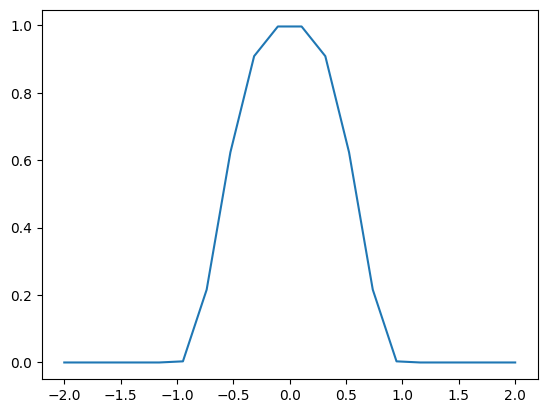

In [169]:
def w(x: float) -> float:
    if np.abs(x) >= 1:
        return 0
    return (1 - np.abs(x)**3 )**3

x = np.linspace(-2, 2, 20)
w_ = [w(x_i) for x_i in x]

# 別のやり方
# w = (1 - np.abs(x)**3)**3
# w[np.abs(x) >= 1] = 0
plt.plot(x, w_)

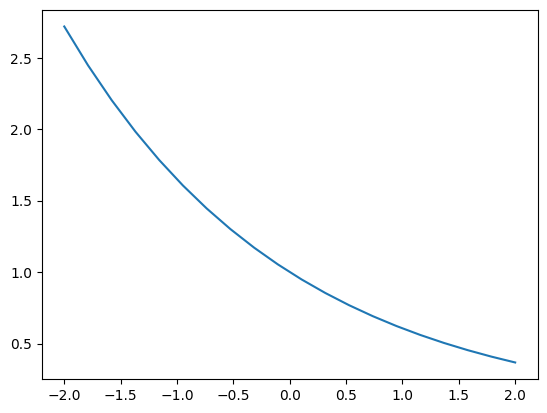

In [163]:
x = np.linspace(-2, 2, 20)
w = np.exp(- x / 2)
plt.plot(x, w)

In [155]:
r = 10
n = len(x)
i = 0

dists = []
for j in range(n):
    dist = np.abs(x[i] - x[j])
    dists.append(dist)

idx = np.argsort(dists)[:5]

In [149]:
x = np.linspace(0, 1, 10)[::-1]
idx = np.argsort(x)[:3]
x[idx]

array([0.        , 0.11111111, 0.22222222])

## 最近のアルゴリズム？

Wikipediaなどを参考にしたもの：

LOWESSは重み付き線形回帰の一般化で、あるデータ点$(x_i, y_i)$について、$x$によって変化する重み$w(x)$を用いた重み付き回帰を行う

2つのデータ点の特徴量ベクトル$x, x' \in \mathbb{R}^m$（$m$は特徴量の次元数）の距離を使って重みとし、局所回帰を実現する

重みには標準的にはGaussian weight function

$$
w(x, x', \alpha)=\exp \left(-\frac{\|x-x'\|^2}{2 \alpha^2}\right)
$$

が使われるらしい。


基本的に散布図で用いられるので$\boldsymbol{x} = (1, x_1)^\top, \boldsymbol{\beta} = (\beta_0, \beta_1)^\top$ となり

$$
\boldsymbol{\beta}
= \arg \min_{\boldsymbol{\beta}}
\sum^k_{i=1} w(x_i, x_j) (y_i - \beta_0 - \beta_1 x_i)^2
$$

と推定する

$W$を$n\times n$の対称行列とする。

$$
\boldsymbol{\beta} = (\boldsymbol{X}^\top W \boldsymbol{X})^{-1} \boldsymbol{X}^\top W \boldsymbol{y}
$$

## 参考

- [Local regression - Wikipedia](https://en.wikipedia.org/wiki/Local_regression)
- Cleveland, W. S. (1979). [Robust locally weighted regression and smoothing scatterplots.](https://sites.oxy.edu/lengyel/m150/other/Robust%20Locally%20Weighted%20Regression%20and%20Smoothing%20Scatterplots_JASA1997_Cleveland.pdf) Journal of the American statistical association, 74(368), 829-836.



## 実装

### statsmodelsの実装

[LOWESS Smoother - statsmodels 0.14.4](https://www.statsmodels.org/stable/examples/notebooks/generated/lowess.html)

In [107]:
# データを生成
import numpy as np
np.random.seed(0)
x = np.linspace(0, 5, 100)
y = np.sin(x) + np.random.normal(0, 0.2, 100)

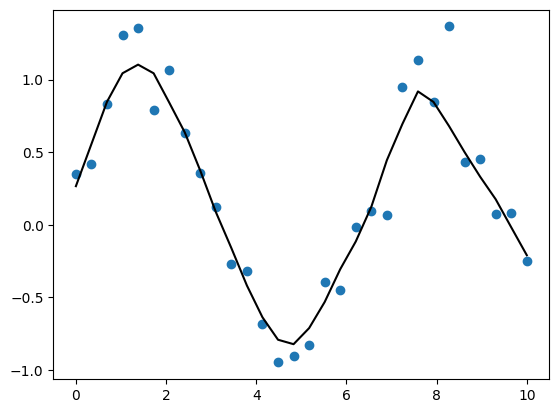

In [115]:
import statsmodels.api as sm
smoothed = sm.nonparametric.lowess(exog=x, endog=y, frac=0.2, it=3)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")
fig.show()

### numpyのみでの実装

Wikipediaなどを参考にそれっぽくできたが最初に提案された論文とは違う

In [109]:
class WLS:
    """距離で重みを付けた回帰"""

    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        # 重みの計算
        n, m = X.shape
        W = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                W[i, j] = np.exp(-( np.linalg.norm(X[i,:] - X[j, :])**2 / 2 * self.alpha))
        
        # 推定
        self.beta_ = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y
        return self

    def predict(self, X):
        return X @ self.beta_


def add_const(x):
    # 定数項のための1だけの列を追加する
    n = len(x)
    X = np.vstack([np.ones_like(x), x]).T
    return X


In [110]:
# これらでWSLができる
X = add_const(x)
WLS(alpha=0.1).fit(X, y).beta_

array([ 1.2130558 , -0.41742293])

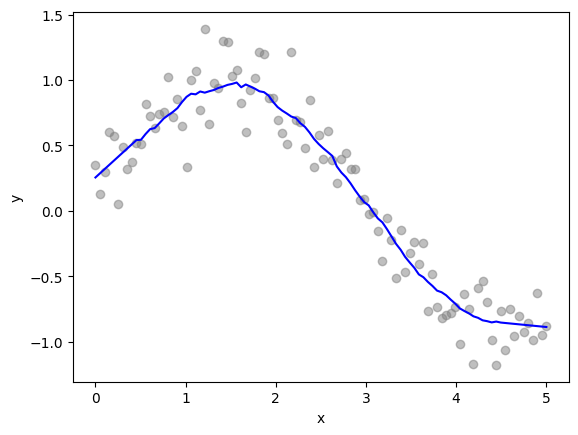

In [111]:
# LOWESSの例
frac = 0.2 # サンプルの何割を局所回帰に使うか
alpha = 0.1

n = len(x)
k = int(np.ceil(frac * n))
y_smoothed = np.zeros_like(y)
delta = np.ones_like(y)

for i in range(n):
    # 各点iについて距離を計算し、近傍のデータを取得
    dist = np.abs(x - x[i])
    idx = np.argsort(dist)[:k]
    x_local = x[idx]
    y_local = y[idx]

    # x_localに対する重み付き線形回帰を行う
    X_local = add_const(x_local)
    X = add_const(x[[i]])
    y_smoothed[i] = WLS(alpha=alpha).fit(X_local, y_local).predict(X[0,:])


# 結果をプロット
fig, ax = plt.subplots()
ax.scatter(x, y, label='Data', color='gray', alpha=0.5)
ax.plot(x, y_smoothed, label='LOWESS Fit (numpy)', color='blue')
ax.set(xlabel='x', ylabel='y')
fig.show()

In [112]:
def lowess(x, y, frac=0.2, it=3, alpha=0.1):
    """
    Args:
        x (ndarray): 説明変数
        y (ndarray): 目的変数
        frac (float): スパン（データ範囲の割合）
        it (int): 外れ値対策の反復回数
    """
    n = len(x)
    k = int(np.ceil(frac * n))  # スパンを元に近傍のサイズを計算
    y_smoothed = np.zeros_like(y)
    delta = np.ones_like(y)
    
    for _ in range(it):
        for i in range(n):
            # 各点iについて距離を計算し、近傍のデータを取得
            dist = np.abs(x - x[i])
            idx = np.argsort(dist)[:k]
            x_local = x[idx]
            y_local = y[idx]

            # x_localに対する重み付き線形回帰を行う
            X_local = add_const(x_local)
            X = add_const(x[[i]])
            y_smoothed[i] = WLS(alpha=alpha).fit(X_local, y_local).predict(X[0,:])

        # 外れ値の影響を減らすため、差分に基づいて重みを更新
        residuals = np.abs(y - y_smoothed)
        delta = residuals / residuals.max()
        delta = 1 / (1 + delta)

    return y_smoothed

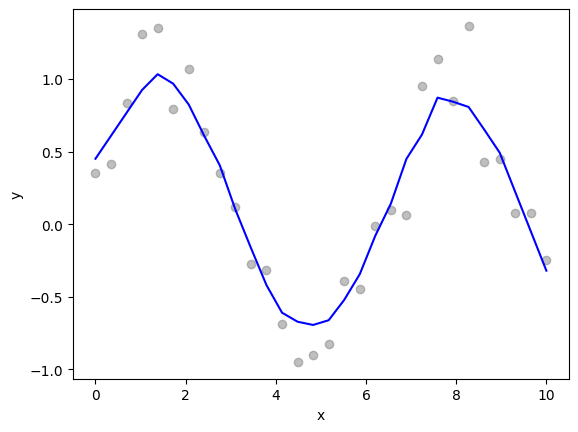

In [114]:
y_smoothed = lowess(x, y, frac=0.2, it=2, alpha=0.1)

# 結果をプロット
fig, ax = plt.subplots()
ax.scatter(x, y, label='Data', color='gray', alpha=0.5)
ax.plot(x, y_smoothed, label='LOWESS Fit (numpy)', color='blue')
ax.set(xlabel='x', ylabel='y')
fig.show()